In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import requests
from scipy.integrate import quad
from scipy.optimize import curve_fit, minimize

from src.maths.Error import r_squared
from src.network.Genetic import de
from src.plotter.Plotter import Plotter

In [2]:
data = requests.get('http://v5464.hosted-by-vdsina.com:8000/science/phases/?format=json&limit=1000').json()['results']
temperature = np.array([dat['temperature'] for dat in data], dtype=np.float32)
pressure = np.array([dat['pressure'] for dat in data], dtype=np.float32)
density = np.array([dat['density'] for dat in data], dtype=np.float32)

sort_mask = np.lexsort((temperature, pressure, density))
temperature = temperature[sort_mask]
pressure = pressure[sort_mask]
density = density[sort_mask]

saturation_data = \
requests.get('http://v5464.hosted-by-vdsina.com:8000/science/saturations/?format=json&limit=81&offset=81').json()[
    'results']
saturation_temperature = np.array([dat['temperature'] for dat in saturation_data])
saturation_pressure = np.array([dat['pressure'] for dat in saturation_data])
saturation_density = np.array([dat['density'] for dat in saturation_data])
sort_mask = np.lexsort((saturation_temperature, saturation_pressure, saturation_density))
saturation_temperature = saturation_temperature[sort_mask]
saturation_pressure = saturation_pressure[sort_mask]
saturation_density = saturation_density[sort_mask]

linearized_temperature = (temperature - min(temperature)) / (max(temperature) - min(temperature))
linearized_pressure = (pressure - min(pressure)) / (max(pressure) - min(pressure))
linearized_density = (density - min(density)) / (max(density) - min(density))

In [3]:
M = 200.592e-3
R = 8.31
N_a = 6e24

critical_temperature = 1490 + 273.15
critical_pressure = 1510e5
critical_density = 5500

temperature_set = np.array(list(set(temperature)), dtype=np.float32)
temperature_set.sort()

pressure_set = np.array(list(set(pressure)), dtype=np.float32)
pressure_set.sort()

density_set = np.array(list(set(density)), dtype=np.float32)
density_set.sort()

In [4]:
plt.rcParams.update({'font.size' : 16})
%matplotlib qt

In [5]:
def viral_equation(x, a):
    return x + a * x ** 2


def known_fit_function(x):
    return -1.793e-2 / (x / 100) + 2.51e-2 / (x / 100) ** 2 + 1.071e-3


def fit_function(x, a, b, c):
    return a / x + b / x ** 2 + c


def fit_function_derivative(x, a, b, c):
    return -2 * a / x ** 3 - 3 * b / x ** 4


def fit_function_boyle(x, a, b, c):
    return c * x ** 3 + a * x + b


B, B_temperature, B_error = [], [], []
for temp in temperature_set:
    mask = (temperature == temp)
    density_temp = density[mask]
    pressure_temp = pressure[mask]
    temperature_temp = temperature[mask]
    Z_temp = pressure_temp * M / (R * temperature_temp)

    if len(Z_temp) < 16:
        continue

    fit = curve_fit(viral_equation, density_temp, Z_temp)
    B.append(fit[0][0])
    B_error.append(r_squared(Z_temp, viral_equation(density_temp, *fit[0])))
    B_temperature.append(temp)

B = np.array(B)
B_temperature = np.array(B_temperature)
index = np.lexsort((B, B_temperature))
B, B_temperature = B[index], B_temperature[index]
fit_popt, fit_pcov = curve_fit(fit_function, B_temperature, B)
print(fit_popt)

B_temperature_linspace = np.linspace(np.min(B_temperature), np.max(B_temperature), 1000)
B_linspace = fit_function(B_temperature_linspace, *fit_popt)

[-5.01585148e-01  4.44924300e+00  1.70407337e-04]


In [6]:
# def second_viral(x, a=None, b=None):
#     return R * critical_temperature / (8 * critical_pressure * x) * (x - 27 / 8 * critical_temperature)

# def second_viral(x, a=None):
#     return 27 / 64 * R * critical_temperature ** 2 / critical_pressure * (1 - 27 / 8 * 1 / x)

def coeff(x, a, b, c, d, e, f):
    return a * np.exp(-b / x) + c * np.exp(-d / x) + e / x + f / x ** 2


boyle_temperature = 27 / 8 * critical_temperature


def second_viral(x, a, b, c, d, e):
    return a * np.exp(-b / x) + c * np.exp(-d / x) + e / x


def second_viral_dev(x, a, b, c, d, e):
    return a * b / x ** 2 * np.exp(-b / x) + c * d / x ** 2 * np.exp(-d / x) - e / x ** 2


def second_viral_dev2(x, a, b, c, d, e):
    return (-2 * a * b / x ** 3 + a * b ** 2 / x ** 4) * np.exp(-b / x) + (-2 * c * d / x ** 3 + c * d ** 2 / x ** 4) * np.exp(-d / x) + 2 * e / x ** 3


second_viral_popt, second_viral_pcov = curve_fit(second_viral, B_temperature, B, maxfev=5000)
print(second_viral_popt)

second_viral_error = r_squared(B, second_viral(B_temperature, *second_viral_popt))
second_viral_error = np.round(second_viral_error, 4)

plt.figure(layout='compressed', figsize=(7, 6))
plotter = Plotter(dimension='2d')
plotter.scatter(B_temperature, B, label='Экспериментальные данные', s=50, color='b')
# plotter.plot(
#     B_temperature_linspace, second_viral(B_temperature_linspace, *second_viral_popt),
#     label=rf'Fit function $R^2={second_viral_error}$', color='r'
# )
# plotter.plot(B_temperature_linspace, B_linspace)
# plotter.plot(B_temperature_linspace, known_fit_function(B_temperature_linspace))
plotter.xlabel(r'$T$ $(K)$')
plotter.ylabel(r'$B_2 (T)$')
plotter.legend()
plotter.grid(True)
plotter.show()

[-58.3160306  -19.30768753  58.31620114 -19.31167749  -0.7378304 ]


In [7]:
viral_temperature = np.linspace(min(temperature), max(temperature))
viral_density = np.linspace(min(density), max(density))
viral_temperature, viral_density = np.meshgrid(viral_temperature, viral_density)
viral_pressure = R * viral_temperature / M * viral_equation(viral_density, second_viral(viral_temperature, *second_viral_popt))


r = r_squared(R * temperature / M * viral_equation(density, second_viral(temperature, *second_viral_popt)), pressure)
r = np.round(r, 5)

plt.rcParams.update({'font.size' : 16})
plt.figure(layout='compressed', figsize=(9, 8))
ax = plt.axes(projection='3d')
ax.scatter(temperature, pressure, density, label='Экспериментальные данные', s=50, color='b')
surface = ax.plot_surface(viral_temperature, viral_pressure, viral_density, cmap='jet', alpha=0.5, label='Вириальное уравнение состояния $R^2=%s$' %r)
ax.set_xlabel(r'$T$ $(K)$', labelpad=10, fontsize=18)
ax.set_ylabel(r'$p$ $(Па)$', labelpad=10, fontsize=18)
ax.set_zlabel(r'$\rho$ $(\dfrac {кг} {м^3})$', labelpad=12, fontsize=18)
plt.colorbar(surface, ax=ax, label=r'$\rho (\dfrac {кг} {м^3})$', shrink=0.75, pad=0.15)
plt.legend()
plt.show()

In [20]:
print(R * critical_temperature / (critical_pressure * 8))

1.2128954056291392e-05


In [27]:
Z = pressure * M / (R * temperature)

Z_viral = viral_equation(density, second_viral(temperature, *second_viral_popt))
viral_error = r_squared(Z_viral, Z)
viral_error = np.round(viral_error, 6)

plotter = Plotter(dimension='2d')
plotter.scatter(density, Z, alpha=0.5, label='Experimental data')
plotter.scatter(density, Z_viral, alpha=0.5, label=rf'Viral equation of state $R^2={viral_error}$')
plotter.grid(True)
plotter.legend()
plotter.xlabel(r'$\rho (kg/m^3)$')
plotter.ylabel(r'$\frac {p \mu} {RT} (kg/m^3)$')
plotter.show()

In [9]:
plotter = Plotter(dimension='2d')
for temp in B_temperature:
    mask = (temp == temperature)
    B_index = (temp == B_temperature)
    B_pressure = viral_equation(density[mask], *B[B_index]) * R * temperature[mask] / M
    plotter.scatter(pressure[mask], B_pressure, color='b')
plotter.plot([np.min(pressure), np.max(pressure)], [np.min(pressure), np.max(pressure)], label='y(x)=x', color='r')
plotter.plot()
plotter.grid(True)
plotter.legend()
plotter.xlabel(r'$p_{exp}$')
plotter.ylabel(r'$p_{viral}$')
plotter.show()

In [30]:
def fit_second_viral(x, a, b, c):
    return a / x ** 2 + b / x ** 4 + c

def fit_second_viral_dev(x, a, b, c):
    return -2 * a / x ** 3 - 4 * b / x ** 5

def fit_second_viral_dev2(x, a, b, c):
    return 6 * a / x ** 4 + 20 * b / x ** 6

fit_second_viral_popt, fit_second_viral_pcov = curve_fit(fit_second_viral, B_temperature, B)
r = r_squared(fit_second_viral(B_temperature, *fit_second_viral_popt), B)
r = np.round(r, 4)

plt.figure(layout='compressed', figsize=(7, 6))
plotter = Plotter(dimension='2d')
plotter.scatter(B_temperature, B, color='b', label='$B_2$, вычисленный из аппроксимации', s=50)
plotter.plot(
    B_temperature_linspace, fit_second_viral(B_temperature_linspace, *fit_second_viral_popt), 
    color='r', label=rf'$B_2(T)$, $R^2={r}$'
)
plotter.legend()
plotter.xlabel(r'$T$ $(K)$', fontsize=20)
plotter.ylabel(r'$B_2(T)$', fontsize=20)
# plotter.grid(True)
plotter.show()
print(fit_second_viral_popt)

[-4.11092838e+02  6.97679861e+07  1.63481286e-05]


In [52]:
viral_temperature = np.linspace(min(temperature), max(temperature))
viral_density = np.linspace(min(density), max(density))
viral_temperature, viral_density = np.meshgrid(viral_temperature, viral_density)
viral_pressure = R * viral_temperature / M * viral_equation(viral_density, fit_second_viral(viral_temperature, *fit_second_viral_popt))

r = r_squared(R * temperature / M * viral_equation(density, fit_second_viral(temperature, *fit_second_viral_popt)), pressure)
r = np.round(r, 6)
plt.figure(layout='compressed', figsize=(9, 8))
ax = plt.axes(projection='3d')
ax.scatter(temperature, pressure, density, label='Экспериментальные данные', s=50, c='#333333')
surface = ax.plot_surface(viral_temperature, viral_pressure+1e5, viral_density, cmap='jet', alpha=1, label='Вириальное уравнение состояния $R^2=%s$' %r)
ax.set_xlabel(r'$T$ $(K)$', labelpad=12, fontsize=20)
ax.set_ylabel(r'$p$ $(Па)$', labelpad=12, fontsize=20)
ax.set_zlabel(r'$\rho$ $(кг/м^3)$', labelpad=12, fontsize=20)
cbar = plt.colorbar(surface, ax=ax, shrink=0.75, pad=0.15)
cbar.set_label(r'$\rho$ $(кг/м^3)$', fontsize=20)
plt.legend(edgecolor='k')
plt.show()

In [28]:
Z = pressure * M / (R * temperature)

Z_viral = viral_equation(density, fit_second_viral(temperature, *fit_second_viral_popt))
viral_error = r_squared(Z_viral, Z)
viral_error = np.round(viral_error, 6)
p_viral = Z_viral * R * temperature / M

plt.figure(layout='compressed', figsize=(7, 6))
plt.scatter(pressure, p_viral, color='b', label='Экспериментальные данные')
plt.plot([min(pressure), max(pressure)], [min(pressure), max(pressure)], 'r', label='y(x)=x')
plt.xlabel('$p_{эксп}$')
plt.ylabel('$p_{вир}$')
plt.grid(True)
plt.legend()
plt.show()

# plotter = Plotter(dimension='2d')
# plotter.scatter(density, Z, alpha=0.5, label='Experimental data')
# plotter.scatter(density, Z_viral, alpha=0.5, label=rf'Viral equation of state $R^2={viral_error}$')
# plotter.grid(True)
# plotter.legend()
# plotter.xlabel(r'$\rho (kg/m^3)$')
# plotter.ylabel(r'$\frac {p \mu} {RT} (kg/m^3)$')
# plotter.show()

In [64]:
temperature_linspace = np.linspace(min(temperature), max(temperature))
pressure_linspace = np.linspace(min(pressure), max(pressure))
temperature_linpspace, pressure_linspace = np.meshgrid(temperature_linspace, pressure_linspace)
volume = R * temperature / pressure - 1.793e-2*(100/temperature) + 2.51e-2*(100/temperature) ** 2 + 1.071e-3
volume_linspace = R * temperature_linspace / pressure_linspace - 1.793e-2*(100/temperature_linspace) + 2.51e-2*(100/temperature_linspace) ** 2 + 1.071e-3

plt.figure(layout='compressed', figsize=(6, 6))
ax = plt.axes(projection='3d')
ax.scatter(temperature, pressure, density, color='b')
ax.plot_surface(temperature_linpspace, pressure_linspace, 0.2/volume_linspace, color='r')
plt.show()

In [10]:
%matplotlib qt

In [31]:
viral_temperature_linspace = np.linspace(min(temperature), max(temperature), 50)
viral_density_linspace = np.linspace(min(density), max(density), 50)
viral_temperature_linspace, viral_density_linspace = np.meshgrid(viral_temperature_linspace, viral_density_linspace)
viral_pressure_linspace = R * viral_temperature_linspace / M * (viral_density_linspace + fit_second_viral(viral_temperature_linspace, *fit_second_viral_popt) * viral_density_linspace ** 2)

r = r_squared(viral_equation(density, fit_second_viral(temperature, *fit_second_viral_popt)) * R * temperature / M, pressure)
r = np.round(r, 6)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(temperature, density, pressure, label='Experimental data', zorder=5)
surface = ax.plot_surface(
    viral_temperature_linspace, viral_density_linspace, viral_pressure_linspace, cmap='inferno', alpha=0.5, label='Viral equation of state $R^2=%s$' %r, zorder=0
)
ax.set_xlabel(r'$T (K)$')
ax.set_ylabel(r'$\rho (kg/m^3)$')
ax.set_zlabel(r'$p (Pa)$')
fig.legend(edgecolor='k')
fig.colorbar(surface, ax=ax, label=r'$p (Pa)$', shrink=.75, pad=.2)
fig.show()

In [22]:
A = fit_second_viral_popt[0] * critical_density / critical_temperature ** 2
B = fit_second_viral_popt[1] * critical_density / critical_temperature ** 4
C = fit_second_viral_popt[2] * critical_density
print(A, B, C)

-0.7273167845178855 0.039706416289305976 0.08991395640184985


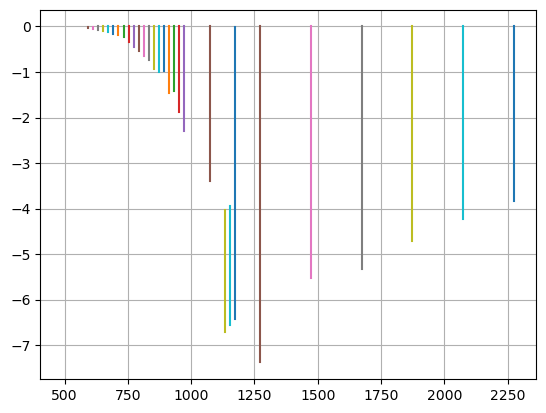

In [10]:
plotter = Plotter(dimension='2d')
for temp in temperature_set:
    mask = (temp == temperature)
    temperature_temp = temperature[mask]
    pressure_temp = pressure[mask]
    density_temp = density[mask]
    plotter.plot(temperature_temp, R * temperature_temp ** 2 * density_temp * second_viral_dev(temperature_temp, *second_viral_popt))
plotter.grid(True)
plotter.show()

In [26]:
27 / 8 * critical_temperature

5950.63125

In [30]:
def LJ(x, eps, sigma, temperature):
    return -4 * eps / temperature * ((sigma / x) ** 12 - (sigma / x) ** 6)


def mayer_function(x, eps, sigma, temperature):
    return (np.exp(LJ(x, eps, sigma, temperature)) - 1) * x ** 2


def mayer_second_viral(temperature, eps, sigma):
    return np.array(
        [-2 * np.pi * quad(mayer_function, 0, 2.5 * sigma, args=(eps, sigma, temp))[0] for temp in temperature]
        )


def fit_second_viral(temperature, a, b, c):
    return np.exp(a / temperature) + b / temperature ** 2 + c


def rmse(a):
    pred = mayer_second_viral(B_temperature, *a)
    error = np.sum((B - pred) ** 2)
    return error


result = minimize(rmse, [400, 2], tol=1e-9)
result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.3707657073515119e-08
        x: [ 1.081e+03  3.787e-02]
      nit: 76
      jac: [-2.442e-15  7.880e-11]
 hess_inv: [[ 7.872e+12 -1.680e+08]
            [-1.680e+08  3.609e+03]]
     nfev: 240
     njev: 80

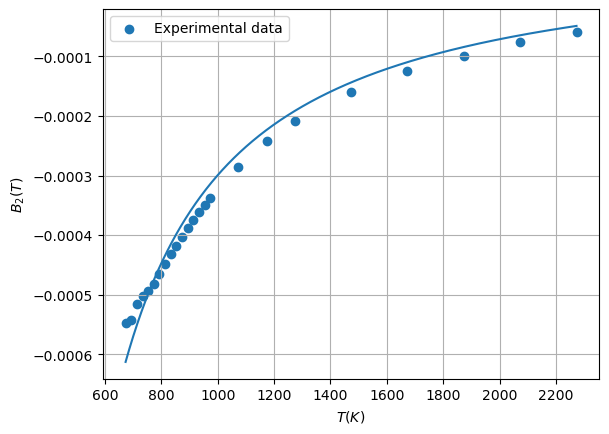

In [31]:
plotter = Plotter(dimension='2d')
plotter.scatter(B_temperature, B, label='Experimental data')
plotter.plot(B_temperature_linspace, mayer_second_viral(B_temperature_linspace, *result.x))
plotter.xlabel(r'$T (K)$')
plotter.ylabel(r'$B_2(T)$')
plotter.legend()
plotter.grid(True)
plotter.show()

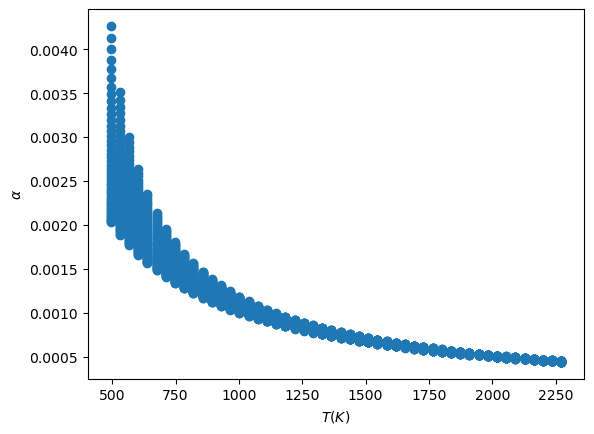

In [32]:
a_temperature = np.linspace(min(temperature), max(temperature))
a_density = np.linspace(min(density), max(density))
a_temperature, a_density = np.meshgrid(a_temperature, a_density)
a_B = fit_function(a_temperature, *fit_popt)
a_B_der = fit_function_derivative(a_temperature, *fit_popt)
a_pressure = R * a_temperature / M * (a_density + a_B * a_density ** 2)
a_Z = a_pressure * M / (R * a_temperature * a_density)
a = 1 / a_temperature * (1 + a_density * (a_B + a_temperature * a_B_der)) / (1 + 2 * a_density * a_B)

plotter = Plotter(dimension='2d')
plotter.scatter(a_temperature, a)
plotter.xlabel(r'$T (K)$')
plotter.ylabel(r'$\alpha$')
plotter.show()

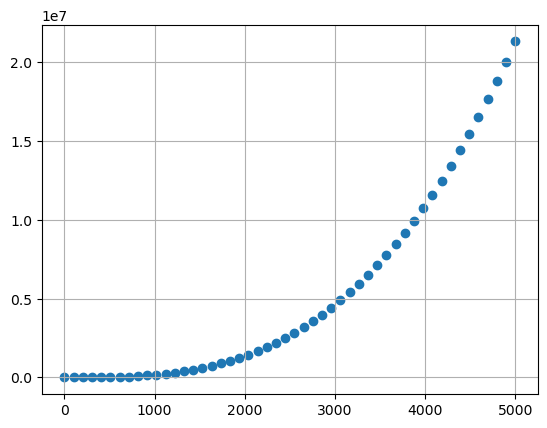

In [33]:
boyle_temperature = np.linspace(0, 5000)
plotter = Plotter(dimension='2d')
plotter.scatter(boyle_temperature, fit_function_boyle(boyle_temperature, *fit_popt))
plotter.grid(True)
plotter.show()

In [19]:
def func(x, a, b):
    pressure, density = x
    return 1 / R * (pressure + a * density ** 2 / M ** 2) * (M / density - b)


popt, pcov = curve_fit(func, (pressure, density), temperature)
print(popt)

van_temperature = func((pressure, density), *popt)
van_error = r_squared(van_temperature, temperature)
van_error = round(van_error, 4)

plotter = Plotter(dimension='3d')
plotter.scatter(temperature, pressure, density, label='Experimental data')
plotter.scatter(van_temperature, pressure, density, label=rf'Van-der-Vaals equation. $R^2 = {van_error}$')
plotter.xlabel(rf'$T(K \degree )$')
plotter.ylabel(rf'$p(Pa)$')
plotter.zlabel(rf'$\rho (kg/m^3)$')
plotter.legend()
plotter.grid(True)
plotter.show()

[7.65561010e-01 2.87305518e-05]


In [36]:
Z = pressure * M / (R * temperature)
Z_van = pressure * M / (R * van_temperature)

plotter = Plotter(dimension='2d')
plotter.scatter(np.log(density), np.log(Z))
# plotter.scatter(np.log(200), np.log())
# plotter.plot(density, Z_van)
plotter.grid(True)
plotter.show()

In [84]:
%matplotlib qt

In [50]:
%matplotlib inline

<h2 align='center'>Second viral coefficient by Difference Evolution</h2>

In [24]:
Z = pressure * M / (R * temperature)


def viral_equation(x, a):
    return x + a[0] * x ** 2


def rmse(a):
    y_pred = viral_equation(density, a)
    return np.sqrt(np.sum(Z - y_pred) ** 2 / len(Z))


result = list(de(rmse, bounds=[(-100, 100)] * 1, its=300))
args, f = result[-1]

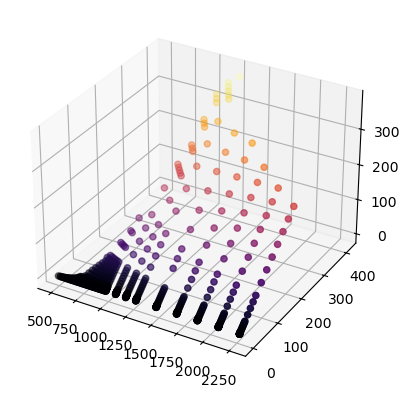

In [25]:
plotter = Plotter(dimension='3d')
plotter.scatter(temperature, density, Z, c=Z, cmap='inferno')
# plotter.plot(density, viral_equation(density, args))
plotter.show()

In [82]:
B_DE = []
for temp in temperature_set:
    temp_mask = (temp == temperature)
    density_temp = density[temp_mask]
    temperature_temp = temperature[temp_mask]
    pressure_temp = pressure[temp_mask]
    Z_temp = pressure_temp * M / (R * temperature_temp)


    def rmse(a):
        y_pred = viral_equation(density_temp, a)
        return np.sqrt(np.sum(Z_temp - y_pred) ** 2 / len(Z_temp))


    result = list(de(rmse, bounds=[(-100, 100)] * 1, its=100, mut=0.7, popsize=20))
    args, f = result[-1]
    B_DE.append(args[0])
    print(f'Temperature: {temp}')

Temperature: 493.1499938964844
Temperature: 513.1500244140625
Temperature: 533.1500244140625
Temperature: 553.1500244140625
Temperature: 573.1500244140625
Temperature: 593.1500244140625
Temperature: 613.1500244140625
Temperature: 633.1500244140625
Temperature: 653.1500244140625
Temperature: 673.1500244140625
Temperature: 693.1500244140625
Temperature: 713.1500244140625
Temperature: 733.1500244140625
Temperature: 753.1500244140625
Temperature: 773.1500244140625
Temperature: 793.1500244140625
Temperature: 813.1500244140625
Temperature: 833.1500244140625
Temperature: 853.1500244140625
Temperature: 873.1500244140625
Temperature: 893.1500244140625
Temperature: 913.1500244140625
Temperature: 933.1500244140625
Temperature: 953.1500244140625
Temperature: 973.1500244140625
Temperature: 1073.1500244140625
Temperature: 1093.1500244140625
Temperature: 1113.1500244140625
Temperature: 1133.1500244140625
Temperature: 1153.1500244140625
Temperature: 1173.1500244140625
Temperature: 1193.1500244140625
T

In [23]:
def mayer_function(x, eps, sigma, temperature):
    return (np.exp(-4 * eps / temperature * ((sigma / x) ** 12 - (sigma / x) ** 6)) - 1) * x ** 2


eps, sigma = 300, 3
viral_B = [-2 * np.pi * quad(mayer_function, 0, 10, args=(eps, sigma, temp))[0] for temp in temperature_set]

In [83]:
plotter = Plotter(dimension='2d')
plotter.scatter(temperature_set, B_DE)
# plotter.plot(temperature_set, viral_B)
plotter.xlabel(r'$T (K \degree )$')
plotter.ylabel(r'$B_2(T)$')
plotter.grid(True)
plotter.show()

In [22]:
args

array([85.77006169])

In [18]:
plt.figure()
Z = pressure * M / (R * temperature * density)

max_pressure_mask = (pressure == 20000000)
max_1_pressure_mask = (pressure == 18000000)
max_2_pressure_mask = (pressure == 16000000)
max_3_pressure_mask = (pressure == 14000000)
max_4_pressure_mask = (pressure == 12000000)
max_5_pressure_mask = (pressure == 10000000)
min_pressure_mask = (pressure == 1000)
min_1_pressure_mask = (pressure == 5000)

ideal_Z = pressure * M / (R * temperature * density)
saturation_Z = saturation_pressure * M / (R * saturation_temperature * saturation_density)
plt.scatter(temperature, Z)
plt.plot(temperature[min_pressure_mask], ideal_Z[min_pressure_mask], label=r'$P=0,01 \bullet 10^5 (Pa)$')
plt.plot(temperature[min_1_pressure_mask], ideal_Z[min_1_pressure_mask], label=r'$P=0,05 \bullet 10^5 (Pa)$')
plt.plot(temperature[max_5_pressure_mask], ideal_Z[max_5_pressure_mask], label=r'$P=100 \bullet 10^5 (Pa)$')
plt.plot(temperature[max_4_pressure_mask], ideal_Z[max_4_pressure_mask], label=r'$P=120 \bullet 10^5 (Pa)$')
plt.plot(temperature[max_3_pressure_mask], ideal_Z[max_3_pressure_mask], label=r'$P=140 \bullet 10^5 (Pa)$')
plt.plot(temperature[max_2_pressure_mask], ideal_Z[max_2_pressure_mask], label=r'$P=160 \bullet 10^5 (Pa)$')
plt.plot(temperature[max_1_pressure_mask], ideal_Z[max_1_pressure_mask], label=r'$P=180 \bullet 10^5 (Pa)$')
plt.plot(temperature[max_pressure_mask], ideal_Z[max_pressure_mask], label=r'$P=200 \bullet 10^5 (Pa)$')
plt.plot(saturation_temperature, saturation_Z, label='Saturation line')
plt.vlines(critical_temperature, 0.9, 1.1, color='r', label='Critical temperature')
plt.xlabel(r'$T(K)$')
plt.ylabel(r'$Z=\frac {pM} {RT \rho}$')
plt.xlim([250, 2500])
plt.ylim([0.9, 1.1])
plt.legend()
plt.grid(True)
plt.show()

In [37]:
plotter = Plotter(dimension='2d')
for index, temp in enumerate(temperature_set):
    mask = (temp == temperature)
    temp_pressure = R / M * temp * viral_equation(density[mask], B[index]) * density[mask]
    plotter.scatter(pressure[mask], temp_pressure)
plotter.grid(True)
plotter.show()

In [1]:
def viral_pressure(x, a):
    return 1 + a * x


A_2 = []
for temp in temperature_set:
    temp_mask = (temp == temperature)
    density_temp = density[temp_mask]
    temperature_temp = temperature[temp_mask]
    pressure_temp = pressure[temp_mask]
    Z_temp = pressure_temp * M / (R * temperature_temp * density_temp)

    popt, pcov = curve_fit(viral_pressure, pressure_temp, Z_temp)
    A_2.append(popt[0])

plotter = Plotter(dimension='2d')
plotter.scatter(temperature_set, A_2)
plotter.grid(True)
plotter.show()

NameError: name 'temperature_set' is not defined

In [18]:
Z = pressure * M / (R * density)
plotter = Plotter(dimension='3d')
plotter.scatter(temperature, density, Z, c=Z, cmap='inferno')
plotter.show()

In [135]:
max(saturation_temperature)

1650.0

In [7]:
%matplotlib qt

In [ ]:
%matplotlib inline

<h2 align='center'>Extension Coefficient</h2>

In [75]:
a = (1 / temperature * (1 + density * second_viral(temperature, *second_viral_popt)) + density * second_viral_dev(temperature, *second_viral_popt)) / (
    1 + 2 * second_viral(temperature, *second_viral_popt) * density)

plt.figure(layout='compressed', figsize=(6, 6))
plotter = Plotter(dimension='2d')
for temp in pressure_set:
    mask = (temp == pressure)
    temp_temperature = temperature[mask]
    temp_pressure = pressure[mask]
    temp_density = density[mask]

    temp_a = -1 / temp_density[0:-1] * np.diff(temp_density) / np.diff(temp_temperature)
    temp_a_density = temp_temperature[0:-1]
    plotter.scatter(temp_a_density, temp_a, color='b')
    # plotter.plot(temperature[mask], a[mask])

plotter.grid(True)
plotter.show()

In [74]:
a = (1 / temperature * (1 + density * second_viral(temperature, *second_viral_popt)) + density * second_viral_dev(temperature, *second_viral_popt)) / (
    1 + 2 * second_viral(temperature, *second_viral_popt) * density)
saturation_a = (1 / saturation_temperature * (1 + saturation_density * second_viral(saturation_temperature, *second_viral_popt)) + saturation_density * second_viral_dev(saturation_temperature, *second_viral_popt)) / (
    1 + 2 * second_viral(saturation_temperature, *second_viral_popt) * saturation_density)

plotter = Plotter(dimension='2d')
for temp in pressure_set:
    mask = (temp == pressure)
    plotter.plot(temperature[mask], a[mask])
plotter.scatter(temperature, a)
# plotter.plot(saturation_temperature, saturation_a)
plotter.grid(True)
plotter.xlabel('$T (K)$')
plotter.ylabel(r'$\alpha$')
plotter.show()

In [109]:
U = 3 / 2 * R * temperature - R * temperature ** 2 * fit_second_viral(temperature, *fit_second_viral_popt) * density

In [113]:
plotter = Plotter(dimension='3d')
plotter.scatter(temperature, density, U, alpha=0.5)
# plotter.plot(temperature[pressure == 2000000], U[pressure == 2000000])
# plotter.plot(temperature[pressure == 20000000], U[pressure == 20000000])
# plotter.plot(temperature[pressure == 18000000], U[pressure == 18000000])
plotter.grid(True)
plotter.show()

In [247]:
cv = 3 / 2 * R - 2 * R * density * temperature * fit_second_viral_dev(temperature, *fit_second_viral_popt) - density * R * temperature ** 2 * fit_second_viral_dev2(temperature, *fit_second_viral_popt)

In [248]:
plotter = Plotter(dimension='2d')
plotter.scatter(temperature, cv, alpha=0.5)
for temp in pressure_set:
    mask = (temp == pressure)
    plotter.plot(temperature[mask], cv[mask])
plotter.grid(True)
plotter.show()

<h2 align='center'> alpha coefficient</h2>

In [121]:
a_exp, a_exp_temperature, a_exp_density = [], [], []
a_viral, a_viral_temperature = [], []
for temp in pressure_set:
    mask = (temp == pressure)
    temp_temperature = temperature[mask]
    temp_pressure = pressure[mask] 
    temp_density = density[mask]
    
    a_exp.extend(-1 / temp_density[0:-1] * np.diff(temp_density) / np.diff(temp_temperature))
    a_exp_temperature.extend(temp_temperature[0:-1])
    a_exp_density.extend(temp_density[0:-1])
    a_viral.extend((1 + fit_second_viral(temp_temperature[1:], *fit_second_viral_popt) * temp_density[1:] + temp_temperature[1:] * temp_density[1:] * fit_second_viral_dev(temp_temperature[1:], *fit_second_viral_popt)) / (temp_temperature[1:] * (1 + 2 * fit_second_viral(temp_temperature[1:], *fit_second_viral_popt) * temp_density[1:])))
    a_viral_temperature.extend(temp_temperature[0:-1])

a_viral = np.array(a_viral)
a_viral[(a_viral<0.00045) & (a_viral > 0.0004)]
# a_viral = (1 + fit_second_viral(temperature, *fit_second_viral_popt) * density + temperature * density * fit_second_viral_dev(temperature, *fit_second_viral_popt)) / (temperature * (1 + 2 * fit_second_viral(temperature, *fit_second_viral_popt) * density))

array([], dtype=float32)

In [122]:
r = r_squared(a_viral, a_exp)
r = np.round(r, 4)

plt.figure(layout='compressed', figsize=(7, 6))
plotter = Plotter(dimension='2d')
plotter.scatter(a_exp_temperature, a_exp, alpha=0.5, label='Experimental data')
plotter.scatter(a_viral_temperature, a_viral, alpha=0.5, label=rf'Equation $R^2={r}$')
plotter.legend(edgecolor='k', fontsize=16)
plotter.grid(True)
plotter.xlabel(r'$T (K)$', fontsize=16)
plotter.ylabel(r'$\alpha (K^{-1})$', fontsize=16)
plotter.show()

In [53]:
temperature[:789][a_exp == min(a_exp)]
pressure[:789][a_exp == min(a_exp)]

array([140000.], dtype=float32)

In [107]:
a_viral_temperature_linspace = np.linspace(min(temperature), max(temperature), 50)
a_viral_density_linspace = np.linspace(min(density), max(density), 50)
a_viral_temperature_linspace, a_viral_density_linspace = np.meshgrid(a_viral_temperature_linspace, a_viral_density_linspace)
a_viral_meshgrid = (1 + fit_second_viral(a_viral_temperature_linspace, *fit_second_viral_popt) * a_viral_density_linspace + a_viral_temperature_linspace * a_viral_density_linspace * fit_second_viral_dev(a_viral_temperature_linspace, *fit_second_viral_popt)) / (a_viral_temperature_linspace * (1 + 2 * fit_second_viral(a_viral_temperature_linspace, *fit_second_viral_popt) * a_viral_density_linspace))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(a_exp_temperature, a_exp_density, a_exp, label='Experimental data')
surface = ax.plot_surface(a_viral_temperature_linspace, a_viral_density_linspace, a_viral_meshgrid, cmap='inferno', alpha=0.5, label='Equation')
plt.colorbar(surface, ax=ax, shrink=.75, pad=.2, label=r'$\alpha (K^{-1})$')
ax.set_xlabel(r'$T(K)$')
ax.set_ylabel(r'$\rho (kg/m^3)$')
ax.set_zlabel(r'$\alpha (K^{-1})$')
plt.tight_layout()
fig.legend(edgecolor='k')
plt.show()

In [112]:
x_ticks_labels = np.linspace(min(a_exp), max(a_exp), 5)
y_ticks_labels = np.linspace(min(a_exp), max(a_exp), 5)

plt.figure(layout='compressed', figsize=(7, 6))
ax = plt.axes()
plt.scatter(a_exp, a_viral, alpha=0.5, s=50)
plt.plot([min(a_exp), max(a_exp)], [min(a_exp), max(a_exp)], color='r', label=r'$y(x)=x$')
plt.grid(True)
plt.legend(edgecolor='k', fontsize=16)
plt.xlabel(r'$\alpha_{эксп}$', fontsize=16)
plt.ylabel(r'$\alpha_{вир}$', fontsize=16)
ax.set_xticks(x_ticks_labels)
ax.set_yticks(y_ticks_labels)
plt.show()

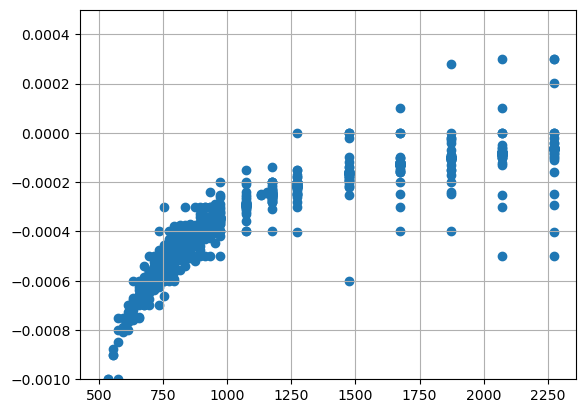

In [62]:
Z = pressure * M / (R * temperature * density)
second_viral_coefficient, second_viral_coefficient_temperature = [], []

for temp in temperature_set:
    mask = (temp == temperature)
    second_viral_coefficient.extend(np.diff(Z[mask]) / np.diff(density[mask]))
    second_viral_coefficient_temperature.extend(temperature[mask][0:-1])

fig = plt.figure()
plt.scatter(second_viral_coefficient_temperature, second_viral_coefficient)
plt.ylim([-0.001, 0.0005])
plt.grid(True)
plt.show()

In [100]:
%matplotlib qt